In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split 
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import nltk
from sklearn.preprocessing import KBinsDiscretizer

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', 100)

In [110]:
# import sys
# !{sys.executable} -m pip install nltk 
# !{sys.executable} -m pip install scikit-learn --upgrade

In [111]:
df = pd.read_csv('~/Desktop/maven_wave/Baker - Lending Club Data - DR_Demo_Lending_Club.csv',
                 index_col='Id',
                 parse_dates=['earliest_cr_line'],
                 dtype={'is_bad': bool})

# Map column to boolean
df['pymnt_plan'] = df.pymnt_plan.map({'y': True, 'n': False})

# Remove 5 records with missing values
bad_ids = [4320, 4329, 4679, 6233, 7593]
df.drop(bad_ids, inplace=True)

In [112]:
print(f'dataset shape = {df.shape}')
print()
print('dtypes:')
print(df.dtypes.value_counts())

dataset shape = (9995, 27)

dtypes:
float64           11
object            11
int64              2
bool               2
datetime64[ns]     1
dtype: int64


In [113]:
# Distribution of response variable
df.is_bad.value_counts(normalize=True)

False    0.870435
True     0.129565
Name: is_bad, dtype: float64

In [114]:
df.sample()

,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,purpose,zip_code,addr_state,debt_to_income,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,
5572,False,Hennepin County,1,RENT,37315.0,not verified,False,NaN,car,"Next Car - Let me pay you, not a bank!",551xx,MN,1.19,0.0,1999-09-01,1.0,NaN,NaN,8.0,0.0,2205,5.6,22.0,f,0.0,3,PC4


In [115]:
df.delinq_2yrs.value_counts()

0.0     8910
1.0      822
2.0      186
3.0       50
4.0       14
5.0        6
6.0        3
7.0        2
11.0       1
8.0        1
Name: delinq_2yrs, dtype: int64

In [116]:
df.mths_since_last_delinq.value_counts();
df[(df.mths_since_last_delinq > 0) & (df.mths_since_last_delinq <= 24)].shape

(1149, 27)

In [117]:
# check for missing values
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)

mths_since_last_record        9155
mths_since_last_delinq        6311
Notes                         3230
emp_title                      589
collections_12_mths_ex_med      27
revol_util                      21
purpose                          4
dtype: int64

In [118]:
df['delinq_2yrs'] = df['delinq_2yrs'].astype(bool)
df.drop(columns=['mths_since_last_delinq'], inplace=True)

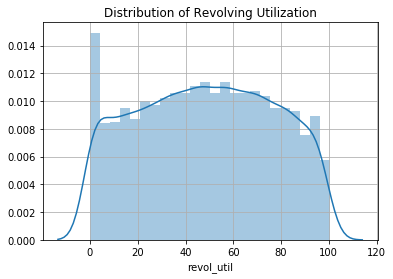

In [119]:
sns.distplot(df.revol_util.dropna());
plt.title('Distribution of Revolving Utilization')
plt.grid();

In [120]:
# Impute missing values
df.loc[df.revol_util.isna(), 'revol_util'] = df.revol_util.dropna().mean()
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)

mths_since_last_record        9155
Notes                         3230
emp_title                      589
collections_12_mths_ex_med      27
purpose                          4
dtype: int64

In [121]:
# Drop this column
df.drop(columns=['collections_12_mths_ex_med','mths_since_last_record'], inplace=True)

In [122]:
# Discretize this column
# df.mths_since_last_delinq.value_counts(dropna=False).sort_index().plot(grid=True);
# plt.title('Months Since Last Delinquent Value');

In [123]:
# df.groupby('mths_since_last_delinq').is_bad.sum().plot(grid=True, figsize=(8, 6));

In [124]:
# df['delinq_less_4_years'] = False
# df['delinq_over_4_years'] = False
# df.loc[df.mths_since_last_delinq <= 48, 'delinq_less_4_years'] = True
# df.loc[df.mths_since_last_delinq > 48, 'delinq_over_4_years'] = True
# df.drop(columns=['mths_since_last_delinq'], inplace=True)

In [125]:
# est = KBinsDiscretizer()
# res = est.fit_transform(df.mths_since_last_delinq.dropna().values.reshape(-1, 1))
# new_df = pd.DataFrame(index=df.mths_since_last_delinq.dropna().index, 
#                       data=res.toarray()).astype(bool)
# new_df.columns = [f'mths_since_last_delinq_{val}' for val in new_df.columns]
# new_df.sample(5)

In [126]:
# df = pd.merge(df, new_df, how='left', left_index=True, right_index=True).drop(columns=['mths_since_last_delinq'])
# df.loc[df.mths_since_last_delinq_0.isna(), 'mths_since_last_delinq_0':'mths_since_last_delinq_4'] = False
# df.sample(5)

In [127]:
# df.loc[:, 'mths_since_last_delinq_0':'mths_since_last_delinq_4'] = df.loc[:, 'mths_since_last_delinq_0':'mths_since_last_delinq_4'].astype(bool)

In [128]:
df.loc[df.emp_length == 'na', 'emp_length'] = np.NaN
df.emp_length = df.emp_length.astype(float)

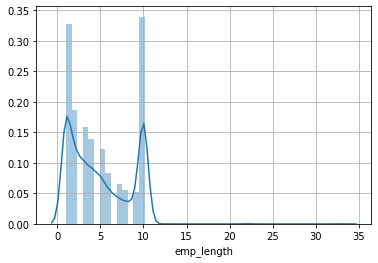

In [129]:
sns.distplot(df.emp_length.dropna());
plt.grid()

In [130]:
df.loc[df.emp_length.isna(), 'emp_length'] = df.emp_length.dropna().mean()

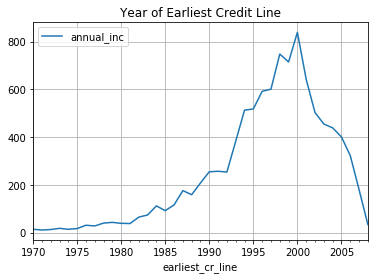

In [131]:
# Some featurization/data cleanup
df.loc[df.earliest_cr_line >= pd.to_datetime('2020-01-01'), 'earliest_cr_line'] = pd.NaT
# df['earliest_cr_cohort_year'] = df.earliest_cr_line.dt.strftime('%Y')
df.set_index('earliest_cr_line')['annual_inc'].resample('Y').size().plot()
plt.legend();
plt.grid()
plt.title('Year of Earliest Credit Line');

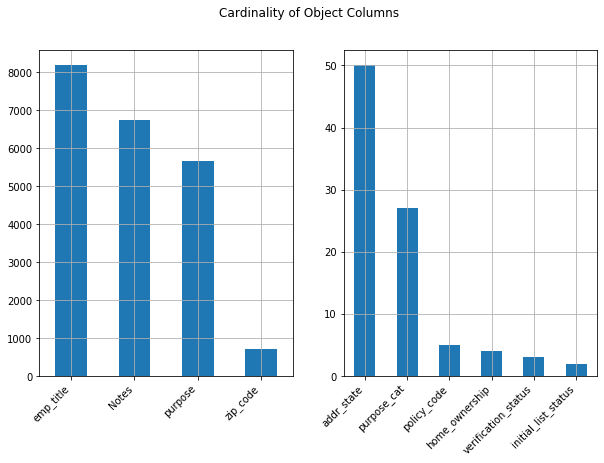

In [132]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
df.select_dtypes(include='object').nunique().sort_values(ascending=False).iloc[:4].plot(kind='bar', grid=True, ax=ax1)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

df.select_dtypes(include='object').nunique().sort_values(ascending=False).iloc[4:].plot(kind='bar', grid=True, ax=ax2)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Cardinality of Object Columns');
# plt.gcf().tight_layout()

In [133]:
def tokenize(text):
        """
        Tokenizes sequences of text and stems the tokens.
        :param text: String to tokenize
        :return: List with stemmed tokens
        """
        tokens = nltk.WhitespaceTokenizer().tokenize(text)
        tokens = list(set(re.sub("[^a-zA-Z\']", "", token) for token in tokens))
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        tokens = list(set(re.sub("[^a-zA-Z]", "", token) for token in tokens))
        stems = []
        stemmer = SnowballStemmer("english")
        for token in tokens:
            token = stemmer.stem(token)
            if token != "":
                stems.append(token)
        return stems 

In [134]:
df['is_small_business'] = df.purpose_cat.map(lambda val: 'small business' in val)
df['purpose_cat_clean'] = df.purpose_cat.map(lambda val: val.replace('small business', '').strip())
df.loc[df.purpose_cat_clean == '', 'purpose_cat_clean'] = 'other'
df.drop(columns=['purpose_cat'], inplace=True)
df.purpose_cat_clean.value_counts()

debt consolidation    4556
other                 1512
credit card           1290
home improvement       811
major purchase         551
car                    352
wedding                252
medical                185
moving                 162
educational            112
house                   97
vacation                96
renewable energy        19
Name: purpose_cat_clean, dtype: int64

In [135]:
# Use Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,3), 
                             stop_words='english', 
                             strip_accents='ascii',
                             min_df=int(df.shape[0]/100),
                             max_df=int(df.shape[0]/10),
                             binary=True)
res = vectorizer.fit_transform(df.purpose.dropna())
print(vectorizer.get_feature_names())
# df.purpose.value_counts().head(50)

['business', 'business loan', 'car', 'card', 'card consolidation', 'card debt', 'cards', 'cc', 'consolidate', 'consolidation loan', 'credit card', 'credit card consolidation', 'credit card debt', 'credit cards', 'debt consolidation loan', 'expenses', 'free', 'help', 'high', 'home', 'home improvement', 'improvement', 'medical', 'moving', 'new', 'pay', 'payoff', 'personal', 'personal loan', 'purchase', 'rate', 'refinance', 'small', 'small business', 'small business loan', 'wedding']


In [136]:
# integer_columns = ['emp_length', 
#                    'delinq_2yrs', 
#                    'inq_last_6mths', 
#                    'mths_since_last_delinq', 
#                    'mths_since_last_record', 
#                    'open_acc', 
#                    'total_acc', 
#                    'mths_since_last_major_derog']
# float_columns = ['debt_to_income', 
#                  'revol_bal', 
#                  'revol_util', 
#                  'annual_inc']
# bool_columns = ['is_bad',
#                 'pymnt_plan']
# obj_columns = ['emp_title', 
#                'home_ownership', 
#                'verification_status', 
#                'Notes', 
#                'purpose_cat_clean',
#                'zip_code', 
#                'addr_state', 
#                'initial_list_status', 
#                'policy_code']
# df.loc[:, integer_columns] = df.loc[:, integer_columns].astype(int)

In [41]:
df.dtypes.sort_values()

is_bad                                   bool
earliest_cr_line               datetime64[ns]
is_small_business                        bool
pymnt_plan                               bool
delinq_2yrs                              bool
mths_since_last_major_derog             int64
revol_bal                               int64
inq_last_6mths                        float64
total_acc                             float64
revol_util                            float64
debt_to_income                        float64
emp_length                            float64
annual_inc                            float64
open_acc                              float64
pub_rec                               float64
policy_code                            object
initial_list_status                    object
verification_status                    object
addr_state                             object
zip_code                               object
purpose                                object
Notes                             

In [137]:
df['zip_code_state'] = df.apply(lambda row: f'{row.zip_code}-{row.addr_state}', axis=1)

In [138]:
df.select_dtypes(include='object').nunique().sort_values(ascending=False)

emp_title              8181
Notes                  6756
purpose                5673
zip_code_state          740
zip_code                720
addr_state               50
purpose_cat_clean        13
policy_code               5
home_ownership            4
verification_status       3
initial_list_status       2
dtype: int64

In [139]:
obj_cols_to_use = df.select_dtypes(include='object').nunique().sort_values(ascending=False).iloc[3:].index.values.tolist()
print(obj_cols_to_use)

['zip_code_state', 'zip_code', 'addr_state', 'purpose_cat_clean', 'policy_code', 'home_ownership', 'verification_status', 'initial_list_status']


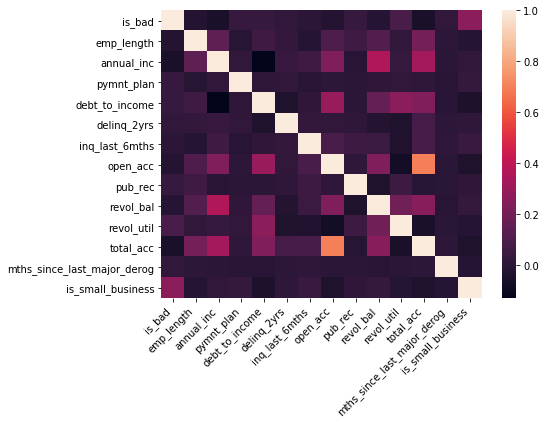

In [140]:
plt.figure(figsize=(8, 6))
corr = df.select_dtypes(include=[np.number, bool]).corr()
# sns.heatmap(corr, annot=False, cmap=plt.cm.Reds)
sns.heatmap(corr, annot=False)
plt.xticks(rotation=45, ha='right')
plt.gcf().tight_layout()

<Figure size 576x432 with 0 Axes>

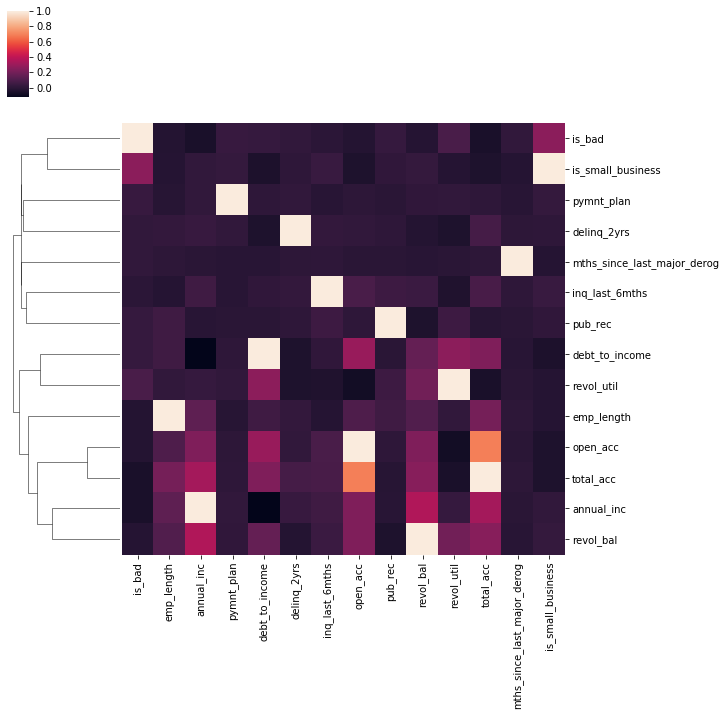

In [141]:
plt.figure(figsize=(8, 6));
sns.clustermap(corr.dropna(), col_cluster=False);
plt.xticks(rotation=45, ha='right');

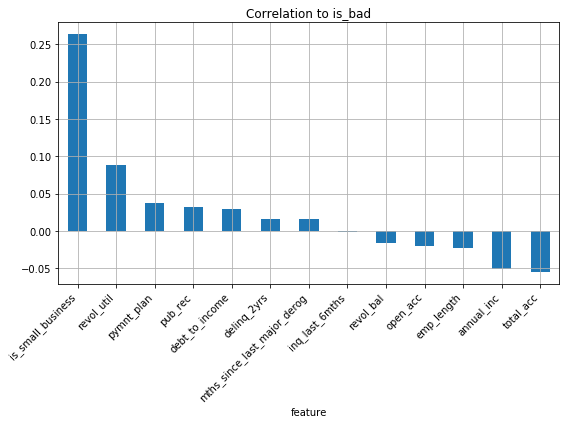

In [142]:
corr_2 = corr.unstack().to_frame('value').reset_index()
corr_2 = corr_2[corr_2.level_0 != corr_2.level_1]

tmp = corr_2[corr_2.level_0 == 'is_bad'].rename(columns={'level_1': 'feature'}).set_index('feature')[
    ['value']].sort_values('value', ascending=False)
tmp.plot(kind='bar', grid=True, legend=None, figsize=(8,6))
plt.title('Correlation to is_bad')
plt.xticks(rotation='45', ha='right')
plt.gcf().tight_layout()

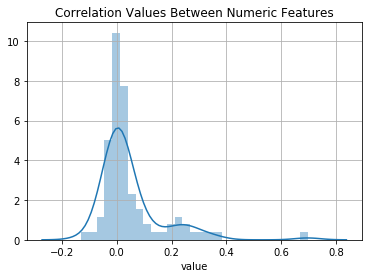

In [143]:
corr_2['features_set'] = corr_2.apply(lambda row: str(sorted([row.level_0, row.level_1])), axis=1)
corr_2 = corr_2.drop_duplicates(subset=['features_set']) \
    .drop(columns=['level_0', 'level_1']) \
    .sort_values('value', ascending=False).dropna()
sns.distplot(corr_2.value)
plt.title('Correlation Values Between Numeric Features')
plt.grid();

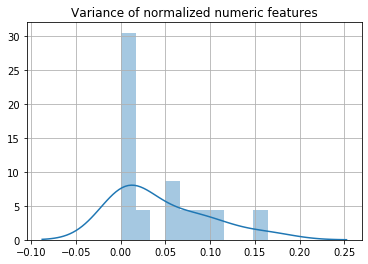

In [144]:
scaler = preprocessing.MinMaxScaler()
df_scale = pd.DataFrame(index=df.select_dtypes(include=[np.number, bool]).index,
                        data=scaler.fit_transform(df.select_dtypes(include=[np.number, bool])),
                        columns=df.select_dtypes(include=[np.number, bool]).columns)
sns.distplot(df_scale.var(), bins=10)
plt.title('Variance of normalized numeric features')
plt.grid()

In [145]:
# Examine feature variance
tmp_2 = (100 * df_scale.var().div(df_scale.var().max())).round(3).sort_values(ascending=False)
print(tmp_2)

mths_since_last_major_derog    100.000
is_bad                          68.587
delinq_2yrs                     58.852
revol_util                      47.752
is_small_business               36.766
debt_to_income                  30.834
total_acc                       10.526
open_acc                         8.629
emp_length                       6.882
pub_rec                          4.265
inq_last_6mths                   2.120
annual_inc                       1.780
revol_bal                        0.270
pymnt_plan                       0.122
dtype: float64


In [146]:
num_cols_to_use = tmp_2.index.values.tolist()
print(num_cols_to_use)

['mths_since_last_major_derog', 'is_bad', 'delinq_2yrs', 'revol_util', 'is_small_business', 'debt_to_income', 'total_acc', 'open_acc', 'emp_length', 'pub_rec', 'inq_last_6mths', 'annual_inc', 'revol_bal', 'pymnt_plan']


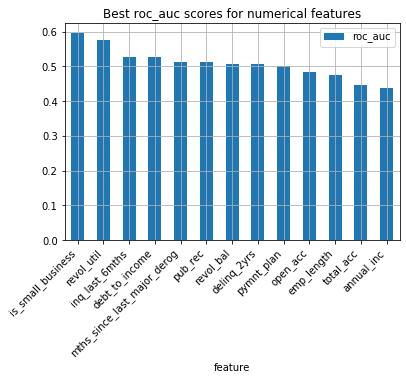

In [147]:
# Compute roc_auc score using numeric features
from sklearn.metrics import roc_auc_score
tmp_df = df[num_cols_to_use].copy()
tmp_df.drop(columns=['is_bad'], inplace=True)
l = []
# tmp_df.apply(lambda col: roc_auc_score(df.is_bad, col))
for col in tmp_df.iteritems():
    new_df = pd.DataFrame(data={'feature': col[1]})
    new_df['label'] = df['is_bad']
    new_df = new_df.dropna()
    val = roc_auc_score(new_df.label, new_df.feature)
    d = {'feature': col[0], 'roc_auc': val}
    l.append(d)
tmp_df_2 = pd.DataFrame(l).sort_values('roc_auc', ascending=False).set_index('feature')
tmp_df_2.plot(kind='bar', grid=True)
plt.xticks(rotation=45, ha='right')
plt.title('Best roc_auc scores for numerical features');

In [148]:
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.datasets import load_iris
# from sklearn.feature_selection import SelectFromModel

In [149]:
cols = sorted(obj_cols_to_use + num_cols_to_use)
print(cols)

['addr_state', 'annual_inc', 'debt_to_income', 'delinq_2yrs', 'emp_length', 'home_ownership', 'initial_list_status', 'inq_last_6mths', 'is_bad', 'is_small_business', 'mths_since_last_major_derog', 'open_acc', 'policy_code', 'pub_rec', 'purpose_cat_clean', 'pymnt_plan', 'revol_bal', 'revol_util', 'total_acc', 'verification_status', 'zip_code', 'zip_code_state']


In [150]:
df_1 = df[cols].copy()
df_2 = pd.get_dummies(df_1)
df_2.shape

(9995, 1551)

In [151]:
varr = df_2.var().sort_values()
varr = varr[varr >= 0.005]
varr.shape

(142,)

In [152]:
# from sklearn.impute import SimpleImputer
# df_3 = pd.DataFrame(index=df_2.set_index('is_bad').index, 
#                     columns=df_2.set_index('is_bad').columns,
#                     data = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(df_2.set_index('is_bad')))
# df_3.reset_index(inplace=True)

In [153]:
X = df_2[varr.index.values.tolist()].copy().drop(columns=['is_bad'])
y = df_2[['is_bad']].copy()

In [154]:
# Split into test and train and make sure evenly sampled data
X_train, X_test, y_train, y_test = train_test_split(X, y) 
print(f'y_train value counts = {y_train.is_bad.value_counts(normalize=True).loc[True]:0.2f}')
print(f'y_test value counts = {y_test.is_bad.value_counts(normalize=True).loc[True]:0.2f}')

y_train value counts = 0.13
y_test value counts = 0.13


In [155]:
# clf = GaussianNB()
clf =  LogisticRegression()
clf.fit(X_train, y_train.values.flatten())
preds = y_test.copy()
preds['y_prob_lr'] = clf.predict_proba(X_test)[:, 1]

In [156]:
# Print roc_auc score
print(f'roc auc score with LogisticRegression = {roc_auc_score(preds.is_bad, preds.y_prob_lr)}')

roc auc score with LogisticRegression = 0.5568324585896629


In [157]:
clf = GaussianNB()
clf.fit(X_train, y_train.values.flatten())
preds['y_prob_nb'] = clf.predict_proba(X_test)[:, 1]

In [158]:
# Print roc_auc score
print(f'roc auc score with Naive Bayes = {roc_auc_score(preds.is_bad, preds.y_prob_nb)}')

roc auc score with Naive Bayes = 0.5949282747833845


In [159]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train.values.flatten())
preds['y_prob_rf'] = clf.predict_proba(X_test)[:, 1]

In [160]:
print(f'roc auc score with RandomForest = {roc_auc_score(preds.is_bad, preds.y_prob_rf)}')

roc auc score with RandomForest = 0.687286666534914


In [161]:
# Use Grid search to find best XGBoost parameters with stochastic column sampling using roc_auc for scoring
param_grid = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [5, 11], 
    'learning_rate': [0.01, 0.1], 
    'colsample_bytree': [0.5, 0.75, 1.0]
}
b = y_train.is_bad.value_counts()
scale_pos_weight = b.loc[False] / b.loc[True]
xgb_grid_clf = GridSearchCV(XGBClassifier(scale_pos_weight=scale_pos_weight),
                            param_grid,
                            cv=3,
                            verbose=10, 
                            scoring='roc_auc', 
                            n_jobs=-1)
xgb_grid_clf.fit(X_train, y_train.values.flatten())

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  4.9min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=6.735810113519092,
                                     subsample=None, tree

In [162]:
model = xgb_grid_clf.best_estimator_ 
params = xgb_grid_clf.best_params_ 
scores = xgb_grid_clf.cv_results_
print(f'best params found: {params}')

best params found: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}


In [163]:
y_test = y_test.copy()

In [164]:
# Print classification report
y_test['y_pred'] = model.predict(X_test) 
y_test['y_prob'] = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test.is_bad, y_test.y_pred))

              precision    recall  f1-score   support

       False       0.91      0.75      0.82      2173
        True       0.23      0.49      0.31       326

    accuracy                           0.72      2499
   macro avg       0.57      0.62      0.57      2499
weighted avg       0.82      0.72      0.75      2499



In [165]:
# Print roc_auc score
print(f'roc auc score on test data = {roc_auc_score(y_test.is_bad, y_test.y_prob)}')

roc auc score on test data = 0.6948325658739861


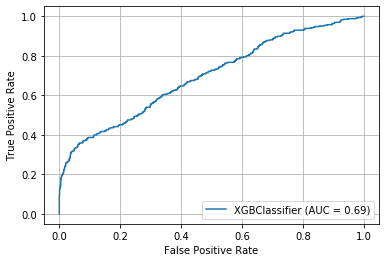

In [166]:
plot_roc_curve(model, X_test, y_test.is_bad)
plt.grid()

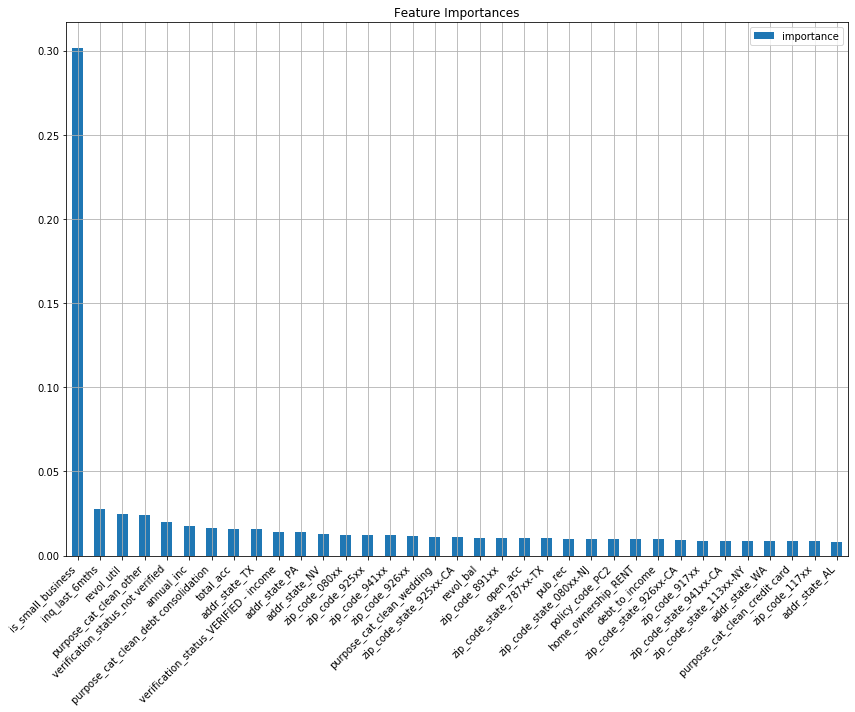

In [167]:
# Plot feature importances
tmp = pd.DataFrame(index=X_test.columns, 
                   data={'importance': model.feature_importances_}).sort_values('importance', ascending=False) 
# tmp[tmp.importance > 0].plot(kind='bar', grid=True, figsize=(12,10)) 
tmp.head(35).plot(kind='bar', grid=True, figsize=(12,10)) 
plt.xticks(rotation=45, ha='right');
plt.title('Feature Importances'); plt.gcf().tight_layout();

In [168]:
# tmp.loc[num_cols_to_use].head(35).plot(kind='bar', grid=True, figsize=(12,10)) 
# plt.xticks(rotation=45, ha='right');
# plt.title('Feature Importances'); 
# plt.gcf().tight_layout();

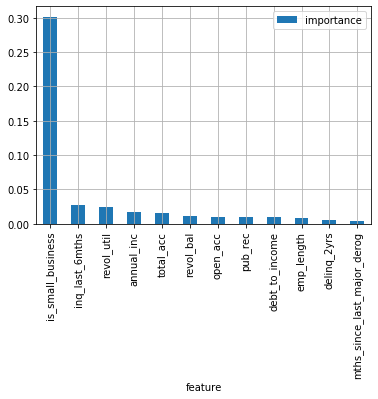

In [169]:
tmp_2 = tmp.reset_index().rename(columns={'index': 'feature'})
tmp_3 = tmp_2[tmp_2.feature.isin(num_cols_to_use)].set_index('feature')
tmp_3.plot(kind='bar', grid=True);

In [170]:
cat = tmp.iloc[0].name
res = df_2[[cat, 'is_bad']]
res.corr()

,is_small_business,is_bad
is_small_business,1.0000,0.2633
is_bad,0.2633,1.0000


In [171]:
cat = tmp.iloc[1].name
res = df_2[[cat, 'is_bad']]
res.corr()

,inq_last_6mths,is_bad
inq_last_6mths,1.000000,-0.001146
is_bad,-0.001146,1.000000


In [172]:
cat = tmp.iloc[2].name
res = df_2[[cat, 'is_bad']]
res.corr()

,revol_util,is_bad
revol_util,1.000000,0.087804
is_bad,0.087804,1.000000


In [173]:
for i in range(tmp.shape[0]):
    cat = tmp.iloc[i].name
    res = df_2[[cat, 'is_bad']]
    print(f'{cat}:{res.corr().iloc[0].is_bad}')

is_small_business:0.26330037333543477
inq_last_6mths:-0.0011462653346675184
revol_util:0.08780415013309932
purpose_cat_clean_other:0.062440491571545104
verification_status_not verified:-0.04995722631157068
annual_inc:-0.05102275919113787
purpose_cat_clean_debt consolidation:0.020160604348367427
total_acc:-0.055307034351278095
addr_state_TX:-0.019489919187139524
verification_status_VERIFIED - income:0.043105122842493994
addr_state_PA:-0.021826774100645957
addr_state_NV:0.03431217047983379
zip_code_080xx:0.01326271435992577
zip_code_925xx:0.024382034647421082
zip_code_941xx:-0.022441212067779596
zip_code_926xx:0.02414027117683048
purpose_cat_clean_wedding:-0.03164203346311608
zip_code_state_925xx-CA:0.024382034647421082
revol_bal:-0.016311810072783855
zip_code_891xx:0.024012961775820813
open_acc:-0.02035571387742111
zip_code_state_787xx-TX:-0.02762993022216255
pub_rec:0.03217396763656981
zip_code_state_080xx-NJ:0.01326271435992577
policy_code_PC2:0.023097477621715188
home_ownership_RENT:

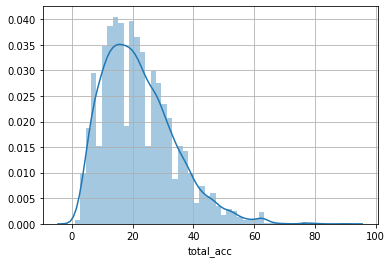

In [174]:
sns.distplot(df_2.total_acc.dropna());
plt.grid();

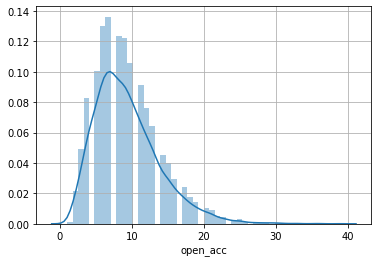

In [175]:
sns.distplot(df_2.open_acc.dropna());
plt.grid();